<a href="https://colab.research.google.com/github/PhonxayMax/Math-and-Architectures-of-Deep-Learning/blob/main/CH10_10_3_1_2dconv_image_smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image smoothing via 2D convolution

In section 10.3.1, we discussed how convolving an image with a smoothing kernel can help eliminate noisy artifacts and produce a smooth output. This notebook contains the fully functional code for the same.

In [1]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def load_grayscale_image(img_path):
    """
    Takes an image path, reads the image as a gray scale image and converts
    the resulting image to a tensor
    """
    return cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

def img_to_tensor(img):
    """
    Takes a numpy array corresponding to an image and converts it to a Pytorch tensor
    """
    return torch.from_numpy(img).float()

def tensor_to_img(x):
    """
    Takes a tensor, does min-max normalization to scale the tensor to a value between 0 and 255
    and returns the resulting numpy array
    """
    x_norm = ((x - x.min()) / (x.max() - x.min())) * 255
    return x_norm.to(torch.uint8).numpy()

First, let us load an image that contains noise. If you look carefully at the image shown below, you can see small white dots present across the entire image. Our goal is to remove these white dots to obtain a cleaner image.

In [6]:
noisy_img = load_grayscale_image("/content/ml_noisy_full_res.png")

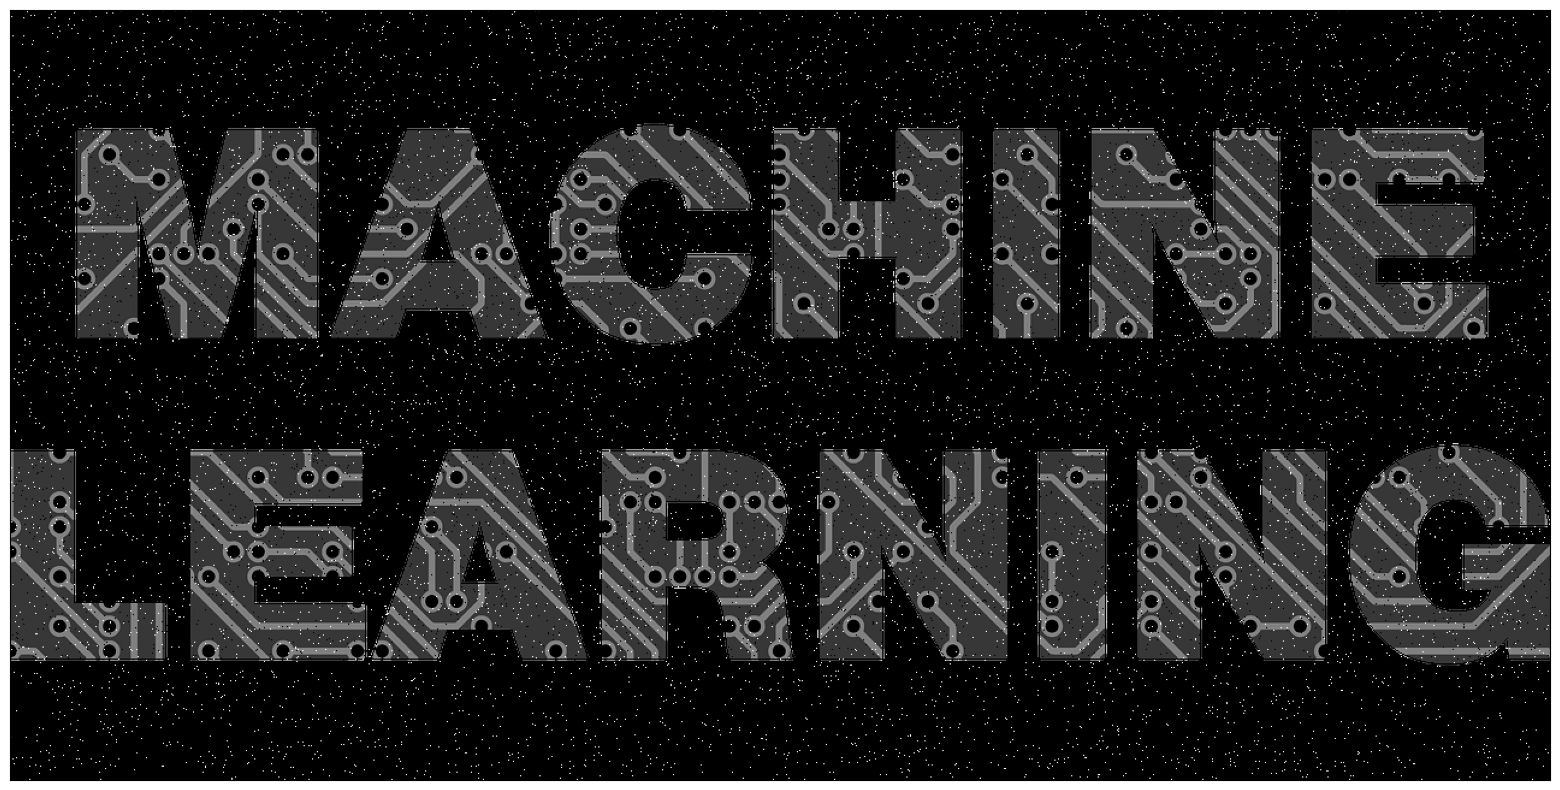

In [7]:
# Let us take a look at the image and plot it
fig = plt.figure(figsize = (20, 10))
plt.xticks([])
plt.yticks([])
imgplot = plt.imshow(noisy_img.astype(np.float32), cmap="gray")

In [8]:
noisy_img_tensor = img_to_tensor(noisy_img)

Let us now define a 3x3 smoothing kernel that we will convolve over the entire image. The smoothing kernel is a uniform matrix with equal weights, i.e.
$$
\begin{bmatrix}
\frac{1}{9} & \frac{1}{9} & \frac{1}{9}\\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9}\\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9}\\
\end{bmatrix}
$$

This means that the output value at any given location is the average of neighbouring 3x3 input pixels. The noisy white pixels are surrounded by black pixels in the input image. Hence, the output pixel would be much closer to a black pixel than a white pixel, resulting in a de-noised output.

In [9]:
# Let us define the smoothing kernel
kernel = torch.tensor([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=torch.float32)
# Conv 2D kernels need to be of shape (out_channel, in_channel, k_x, k_y). Since we are defining a single kernel
# out_channel = in_channel = 1. So we unsqueeze to add those extra dimensions
kernel = kernel.unsqueeze(0).unsqueeze(0)
kernel = kernel/ 9
print(f"Kernel shape {kernel.shape}\nKernel: {kernel}")  # 1x1x3x3
weight = torch.nn.Parameter(data=kernel, requires_grad=False)

Kernel shape torch.Size([1, 1, 3, 3])
Kernel: tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


Let us now convolve the smoothing kernel over the noisy input image. 2D Convolution operations work on 4D tensors of the form (N, C, H, W), where N is the batch size, C is the number of channels, H is height and W is width. Since we are dealing with a single grayscale image, N and C are both 1.

In [10]:
# Convert tensors to N x C x H x W
noisy_img_batch = noisy_img_tensor.unsqueeze(0).unsqueeze(0)

# Convolution can be done in 2 ways.

# 1) Using conv2d function
smooth_img_tensor_1 = F.conv2d(noisy_img_batch, weight, padding=1)

# 2) Using Conv2d layer
conv2d = torch.nn.Conv2d(1, 1, kernel_size=[3, 3], stride=1, padding=0, bias=False)
conv2d.weight = weight
with torch.no_grad():
    smooth_img_tensor_2 = conv2d(noisy_img_batch)

In [11]:
# Let us assert both the ways yielded the same result
assert torch.allclose(smooth_img_tensor_1, smooth_img_tensor_1)

In [12]:
smooth_img_tensor = smooth_img_tensor_2[0][0]
smooth_img = tensor_to_img(smooth_img_tensor)

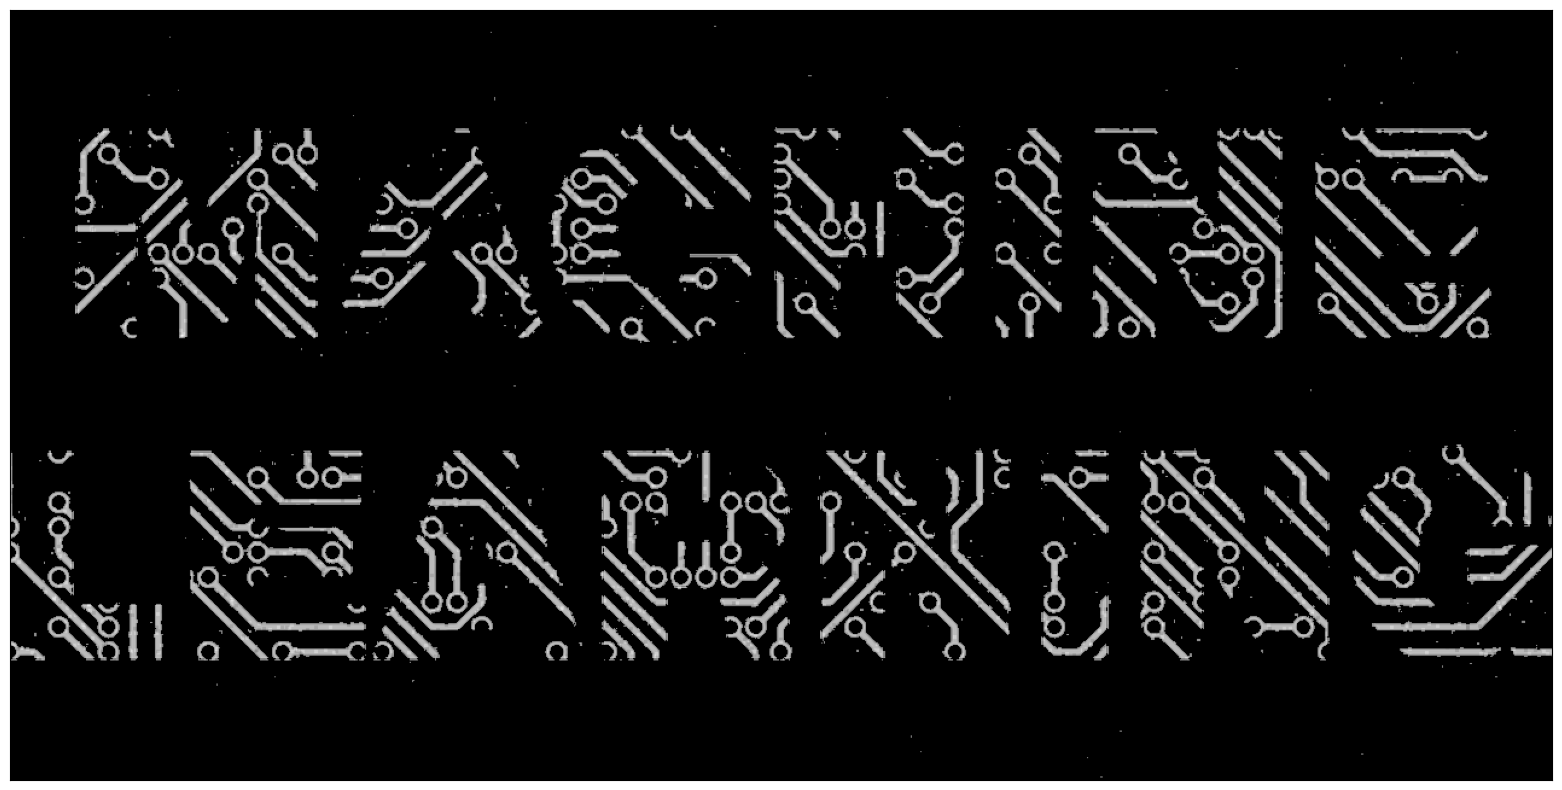

In [13]:
# Let us take a look at the image and plot it
fig = plt.figure(figsize = (20, 10))
# For better visualization, let us threshold the smoothened image before plotting
_, smooth_img = cv2.threshold(smooth_img, 120, 255, cv2.THRESH_TOZERO)
plt.xticks([])
plt.yticks([])
imgplot = plt.imshow(smooth_img.astype(np.float32), cmap="gray")